In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg.interpolative as sli


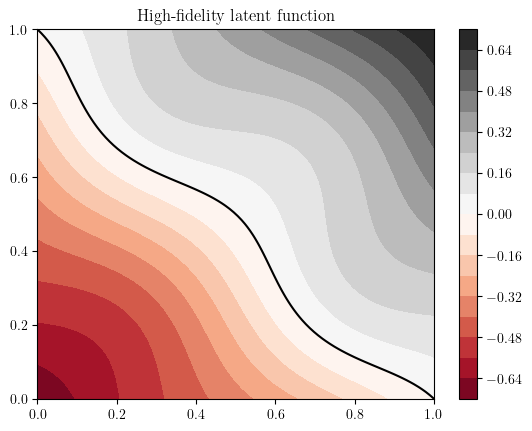

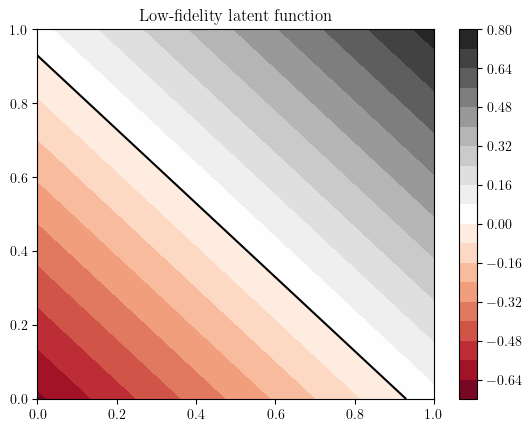

In [2]:
def high_fidelity_latent_function(x):
    assert x.shape[-1] == 2
    
    # Define a hyperplane with normal vector [1, 1] and offset sqrt(2)
    n_hat = np.array([1, 2]) / np.sqrt(5)
    offset = np.sqrt(2) / 2
    
    f = np.dot(n_hat, x) - offset
    
    # Add a sinusoidal perturbation
    f -= 0.1 * np.sin(2 * np.pi * x[0]) * np.sin(2 * np.pi * x[1])
    
    return f


def low_fidelity_latent_function(x):
    assert x.shape[-1] == 2
    
    # Define a hyperplane with normal vector [1, 1] and offset sqrt(2)
    n_hat = np.array([1, 1]) / np.sqrt(2)
    offset = np.sqrt(2) / 2 - 0.05  # Overall, the LF is more likely to ignite, so f is larger
    
    f = np.dot(n_hat, x) - offset
    
    return f


def visualise_latent_functions(f, title):
    # Contour plot of latent
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = f(np.array([X[i, j], Y[i, j]]))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.contourf(X, Y, Z, 20, cmap='RdGy')
    
    # Add line at f=0 contour
    ax.contour(X, Y, Z, levels=[0], colors='black')
    
    fig.colorbar(im)
    ax.set_title(title)
    plt.show()
    
visualise_latent_functions(high_fidelity_latent_function, 'High-fidelity latent function')
visualise_latent_functions(low_fidelity_latent_function, 'Low-fidelity latent function')

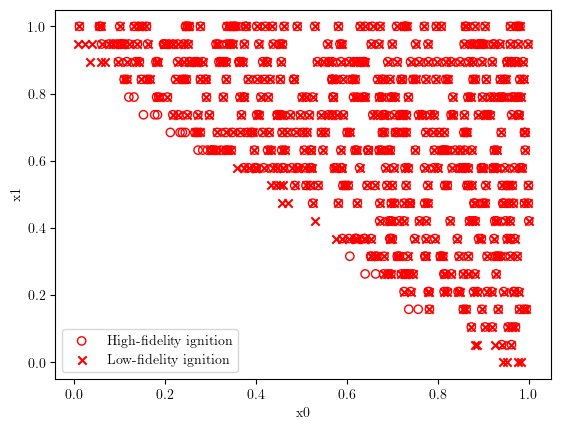

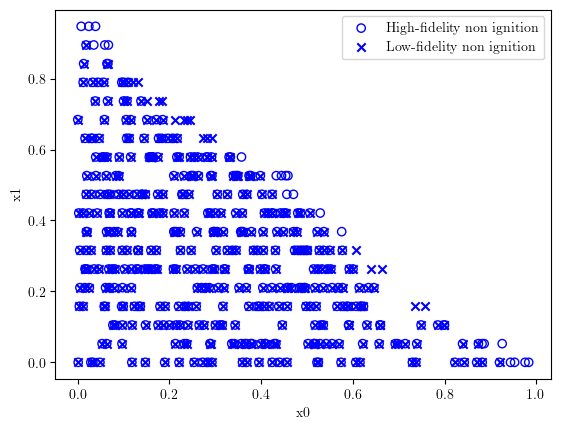

In [3]:
# Synthesize sampling points
np.random.seed(0)
x1 = np.linspace(0, 1, 20)  # Sparse set of samples on x1 axis

N = 1000
sample_points = np.zeros((N, 2))
sample_points[:, 0] = np.random.uniform(0, 1, (N,))
sample_points[:, 1] = x1[np.random.randint(0, len(x1), (N,))]

# Evaluate latent functions amd binarize
yH_latent = np.array([high_fidelity_latent_function(p) for p in sample_points])
yL_latent = np.array([low_fidelity_latent_function(p) for p in sample_points])
yH = (yH_latent > 0).astype(int)
yL = (yL_latent > 0).astype(int)

# Visualise
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(sample_points[yH == 1, 0], sample_points[yH == 1, 1], edgecolors='r', facecolors='none', label='High-fidelity ignition', marker='o')
ax.scatter(sample_points[yL == 1, 0], sample_points[yL == 1, 1], c='r', label='Low-fidelity ignition', marker='x')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(sample_points[yH == 0, 0], sample_points[yH == 0, 1], edgecolors='blue', label='High-fidelity non ignition', marker='o', facecolors='none')
ax.scatter(sample_points[yL == 0, 0], sample_points[yL == 0, 1], c='blue', label='Low-fidelity non ignition', marker='x')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
plt.legend()
plt.show()


/var/folders/6y/1gfy1yb96_59763zctgly20h0000gn/T/ipykernel_44234/2958934416.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(- 30.0 * (x - x0)) ) + 0.25  # Need to add the 0.1 otherwise ID ignores the non-ignited traces


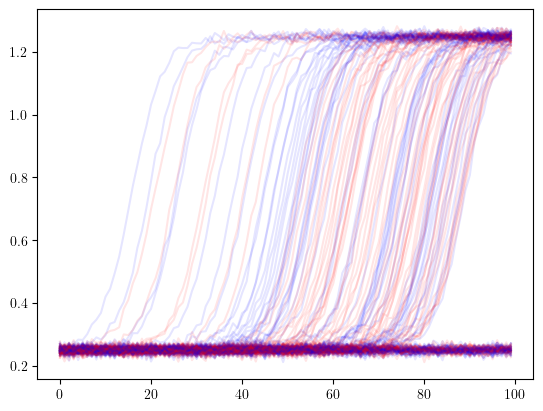

In [4]:
# Now we want to synthesize pressure traces, where the rise time depends on the value of the latent function
# Pressure traces are assumed to be sigmoidal with amplitude 1

# TODO: Add some kind of distributional shift between HF and LF?

def sigmoid(x, x0):
    return 1 / (1 + np.exp(- 30.0 * (x - x0)) ) + 0.25  # Need to add the 0.1 otherwise ID ignores the non-ignited traces

def synthesize_pressure_trace(y):
    time_points = np.linspace(0, 1, 100)
    if y < 0:
        return sigmoid(time_points, 100.0) + 0.01 * np.random.randn(100)  # Flat line
    else:
        return sigmoid(time_points, (0.7 - y) + 0.2) + 0.01 * np.random.randn(100)  # Sigmoidal rise
    
lf_pressure_traces = np.array([synthesize_pressure_trace(y) for y in yL_latent])
hf_pressure_traces = np.array([synthesize_pressure_trace(y) for y in yH_latent])


# Visualise all HF pressure traces
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(100):
    ax.plot(hf_pressure_traces[i, :], c='r', alpha=0.1)
    ax.plot(lf_pressure_traces[i, :], c='b', alpha=0.1)
plt.show()

In [5]:
# Assemble LF data matrix and perform ID

A = lf_pressure_traces.T

k, idx, proj = sli.interp_decomp(A, 0.05, rand=False)

print("Number of bases:", k)
print("Projection matrix shape", proj.shape)

A = A  # Original data matrix
B = A[:,idx[:k]]  # Skeleton matrix
C = A[:,idx[k:]]  # Non - skeleton matrix

assert np.mean(C - B.dot(proj)) < 1e-3

Number of bases: 9
Projection matrix shape (9, 991)


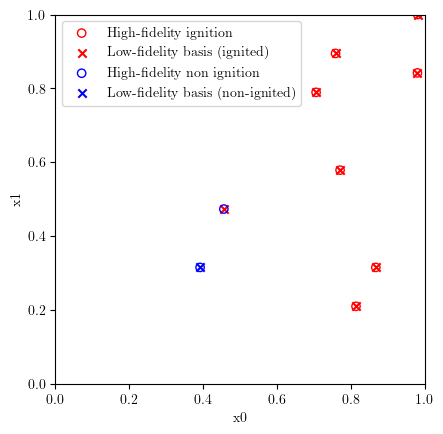

In [6]:
# Extract the sample points which correspond to the basis

sample_points_basis = sample_points[idx[:k], :]
yL_basis = yL[idx[:k]]
yH_basis = yH[idx[:k]]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(sample_points_basis[yH_basis == 1, 0], sample_points_basis[yH_basis == 1, 1], edgecolors='r', facecolors='none', label='High-fidelity ignition', marker='o')
ax.scatter(sample_points_basis[yL_basis == 1, 0], sample_points_basis[yL_basis == 1, 1], c='r', label='Low-fidelity basis (ignited)', marker='x')
ax.scatter(sample_points_basis[yH_basis == 0, 0], sample_points_basis[yH_basis == 0, 1], edgecolors='blue', label='High-fidelity non ignition', marker='o', facecolors='none')
ax.scatter(sample_points_basis[yL_basis == 0, 0], sample_points_basis[yL_basis == 0, 1], c='blue', label='Low-fidelity basis (non-ignited)', marker='x')
ax.set_aspect('equal')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('x0')
ax.set_ylabel('x1')
plt.legend()
plt.show()

# Notes:

Great, this looks like we have a disagreement, where on basis element is predicted to ignited by the LF, but not by the HF. We can use this dataset as the basis for our analysis. First, let's just trial an approach which allows us to estimate where the bi-fidelity ID method has failed, by checked which samples are heavily dependent on the mismatched basis element.

(9, 100)


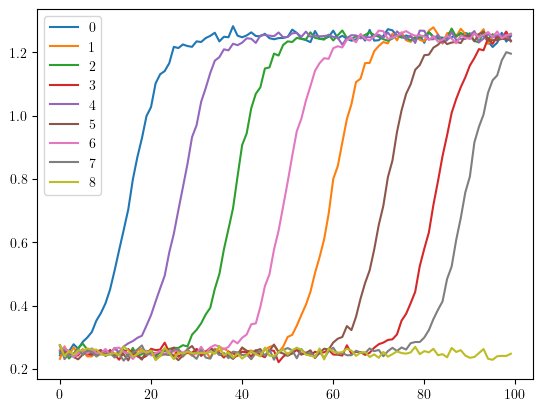

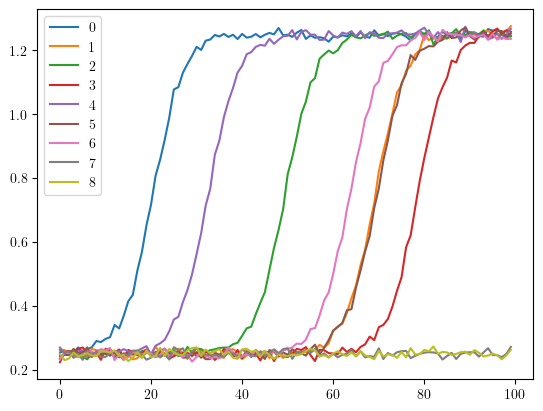

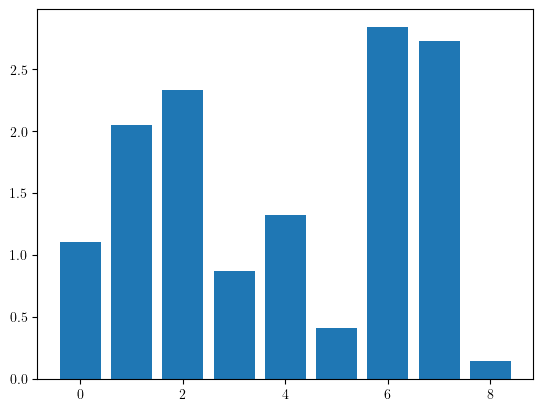

In [7]:
lf_basis_pressure_traces = lf_pressure_traces[idx[:k], :]
hf_basis_pressure_traces = hf_pressure_traces[idx[:k], :]

print(lf_basis_pressure_traces.shape)
for i, lf in enumerate(lf_basis_pressure_traces):
    plt.plot(lf, label=i)
plt.legend()
plt.show()

for i, hf in enumerate(hf_basis_pressure_traces):
    plt.plot(hf, label=i)
plt.legend()
plt.show()

# Compute the L2 norm between each pressure trace pair
l2_norms = [np.linalg.norm(lf - hf) for lf, hf in zip(lf_basis_pressure_traces, hf_basis_pressure_traces)]

plt.bar(range(len(l2_norms)), l2_norms)
plt.show()

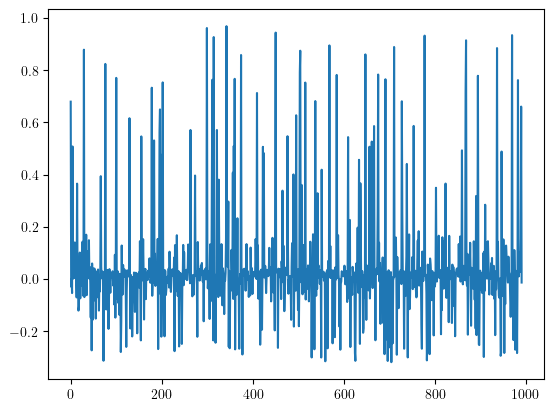

In [8]:
# This is sensible, since index 7 is the mismatched basis element. Let's now try to identify the samples which are most dependent on this basis element.

# Look at row 7 of the projection matrix
plt.plot(proj[7, :])
plt.show()

[342 299 450 969 777 314 868 568 710 936  29 504 647 374  76 503 675 584
 894 100 360 691 311 982 202 515 178 867 409 537 727   0 989 196 495 129
 753 666 263 321 195 476 155 609 183 661 358   4 656 422 859 946 424 198
 633 738 551 356 489 273  66 325 310 636 823  14 507 802 465 449 542 704
 890 559 696 625  72 782 550 529 740 907 346 944 716 377 689 788 910 980
 952 624 945 110 786 228  46 976 592 361 535 192 771 732 370 564 349 455
 700 614 122 347 238 674 728 897 416 896 244 635 575 707 318 313 154 669
 972 783 366 692 613 580 278 199 135 206 844 797 932 891 872 813 146 642
 448 630 420  83 889 131 643 764 490 590 501 879 770 680 532 743  34 837
 686 587 233 660 830 808 831 111 855 292 816 714 988 706 443  48 649 484
 161 341 305 191 406 159  55 950  40  98  44 762 821 966 152 916 885 526
  26 938 279 359   9 913 677 877 107 417 486 540 337 326 852 386 331 306
 637 258 247 511 229 411 112 344 956 712 467 141 570 362 469 955  17  62
 395 815 436 499  78 477 744 156 343 300 720 353 97

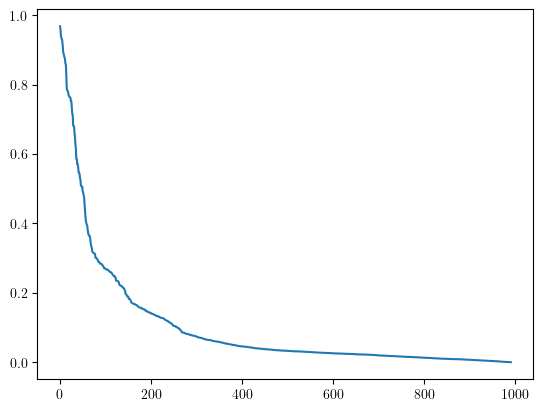

In [9]:
# Now we can identify the samples which are most dependent on this basis element

dependent_samples = np.argsort(np.abs(proj[7, :]))[::-1]

print(dependent_samples)

plt.plot(np.abs(proj[7, dependent_samples]))
plt.show()

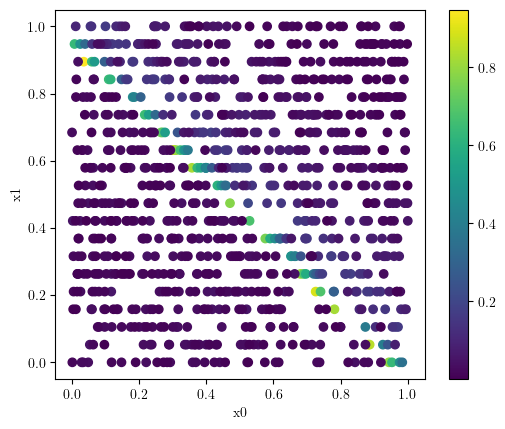

In [10]:
# Visualise this magnitude in parameter space

sample_points_non_basis = sample_points[idx[k:], :]

# Color sample points according to proportional dependence on basis element 7
c = np.abs(proj[7, dependent_samples]) / np.sum(np.abs(proj[:, dependent_samples]), axis=0)

# Check that colors are in [0, 1]
assert np.min(c) >= 0
assert np.max(c) <= 1

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.scatter(sample_points_non_basis[dependent_samples, 0], sample_points_non_basis[dependent_samples, 1], c=c, cmap='viridis')
ax.set_aspect('equal')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
plt.colorbar(im)
plt.show()


(100, 1000)
(100, 991)


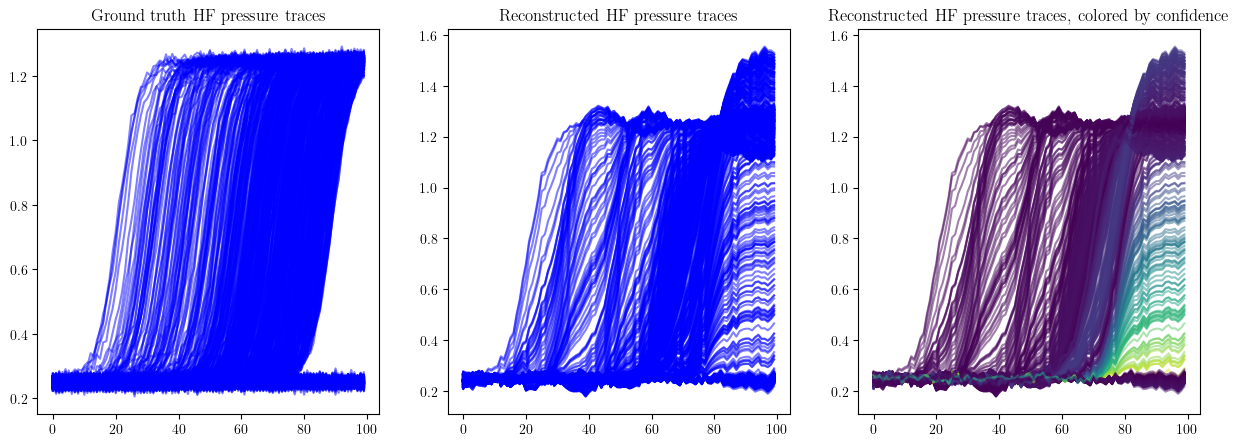

In [26]:
# Compute reconstructed HF pressure traces

A_hf = hf_pressure_traces.T
B_hf = A_hf[:, idx[:k]]
C_hf = A_hf[:, idx[k:]]

print(A_hf.shape)

# Plot original pressure traces
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
for i in range(1000):
    ax.plot(A_hf[:, i], c='blue', alpha=0.5)
plt.title('Ground truth HF pressure traces')

A_hf_reconstructed = B_hf.dot(proj)
print(A_hf_reconstructed.shape)

ax = fig.add_subplot(132)
for i in range(991):
    ax.plot(A_hf_reconstructed[:, i], c='blue', alpha=0.5)
plt.title('Reconstructed HF pressure traces')

cmap = plt.get_cmap('viridis')
c = np.abs(proj[7, :]) / np.sum(np.abs(proj[:, :]), axis=0)
colors = cmap(c)

ax = fig.add_subplot(133)
for i in range(991):
    ax.plot(A_hf_reconstructed[:, i], c=colors[i], alpha=0.5)
plt.title('Reconstructed HF pressure traces, colored by confidence')
plt.show()




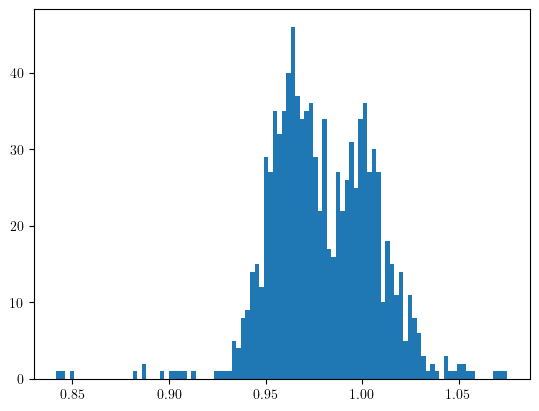

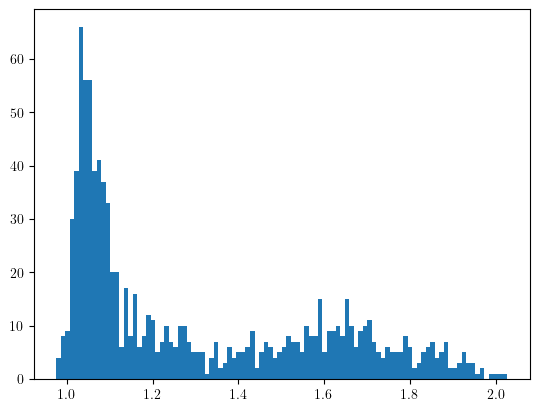

In [31]:
# What is the sum of each column of proj?

plt.hist(np.sum(proj, axis=0), bins=100)
plt.show()

plt.hist(np.sum(np.abs(proj), axis=0), bins=100)
plt.show()

In [ ]:
# This raises the question - can we improve the reconstruction by 1) enforcing constraints that proj is non-negative and 2) each column sums to 1?

# I think I have a theoretical result showing that BFID is exact for linear functions if 2) is satisfied.

# Under this constraint, would the choice of basis columns change?